# Notebook #4: Delivery Delays, CX & NLP

#### Este notebook final têm como objetivo aprofundar a análise da experiência do cliente, cominando as métricas logísticas com as avaliações numéricas e comentários textuais.

#### Enquanto os outros notebooks focavam na limpeza, exploração de dados e compreensão de dataset, esse busca responder o que realmente impacta a experiência do cliente.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords') # significados semânticos relevantes
portuguese_stopwords = stopwords.words("portuguese")

In [66]:
df = pd.read_csv('../data/processed/olist_reviews_text.csv')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delay_time_days,review_score,review_comment_message,customer_city,customer_state,order_category,delay_capped
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,-8.0,4.0,"Não testei o produto ainda, mas ele veio corre...",sao paulo,SP,early,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0,-6.0,4.0,Muito bom o produto.,barreiras,BA,early,-6.0
2,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.0,-13.0,5.0,O produto foi exatamente o que eu esperava e e...,sao goncalo do amarante,RN,early,-13.0
3,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07,12.0,-9.0,1.0,Aguardando retorno da loja,rio de janeiro,RJ,early,-9.0
4,432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,delivered,2018-03-01 14:14:28,2018-03-01 15:10:47,2018-03-02 21:09:20,2018-03-12 23:36:26,2018-03-21,11.0,-9.0,4.0,Gostei do produto,sao paulo,SP,early,-9.0


In [67]:
df.shape

(39094, 16)

Antes de entrar no NLP, é importante filtrar os dados para deixar apenas os que possuem comentários textuais, já que nem todos vêm com avaliações escritas.

In [68]:
nlp_df = df.dropna(subset=['review_comment_message']).copy()
nlp_df.shape

(39094, 16)

Menos da metade dos pedidos possuem comentários textuais. Isso deixa com menos dados para trabalhar mas é algo esperado de e-commerces, já que clientes tendem a dar reviews apenas em experiências muito positivas ou negativas.

In [69]:
nlp_df[['review_score', 'delay_capped']].describe()

,review_score,delay_capped
count,39094.000000,39094.000000
mean,3.773367,-11.443674
std,1.562665,10.792856
min,1.000000,-60.000000
25%,3.000000,-17.000000
50%,5.000000,-12.000000
75%,5.000000,-7.000000
max,5.000000,60.000000


#### Aproximação do sentimento do cliente

Inicialmente será aproximado por nota atribuída ao pedido. Referência para análise exploratória:

In [70]:
def cx_label(score):
    if score >= 4:
        return 'positive'
    elif score >= 3:
        return 'neutral'
    else:
        return 'negative'
    
nlp_df['cx_label'] = nlp_df['review_score'].apply(cx_label)

#### Distribuição de rótulos de avaliação:

Montando o gráfico abaixo, se observa predominância de experiências positivas, mas uma quantidade considerável de negativas. Pode-se investigar se isso pode estar relacionado ao atraso dos pedidos.

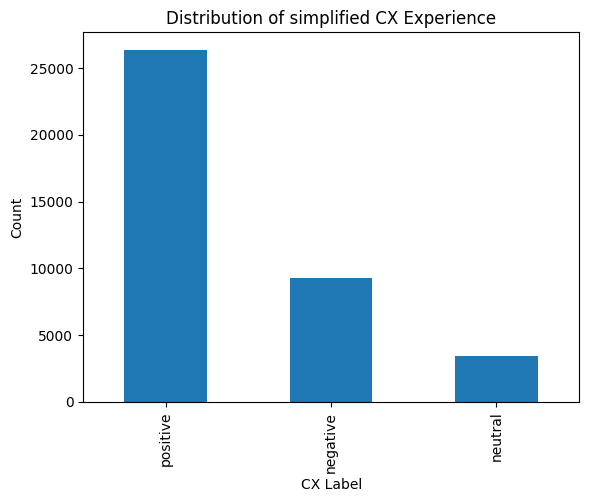

In [71]:
nlp_df['cx_label'].value_counts().plot(kind='bar')
plt.title('Distribution of simplified CX Experience')
plt.xlabel('CX Label')
plt.ylabel('Count')
plt.show()

#### Medida de relação de Delay x Experiência

De acordo com o agrupamento abaixo, se observa que os atrasos dos pedidos avaliados negativamente são, em média, quase o dobro dos avaliados como neutros e mais que o dobro dos positivos.

Este resultado reforça a hipótese de que a percepção do cliente é significantemente afetada pelo tempo de atraso do pedido.

In [72]:
nlp_df.groupby('cx_label')['delay_capped'].agg(['mean', 'median', 'count'])

,mean,median,count
cx_label,,,
negative,-6.072175,-9.0,9283
neutral,-10.747173,-11.0,3449
positive,-13.426295,-13.0,26362


#### Visualização com Boxplot:

O Boxplot abaixo aponta que as experiências negativas apontam maiores incidências de atrasos altos, enquanto a maior parte das experiências positivas e neutras se mantêm nas entregas antecipadas. ou dentro do prazo.

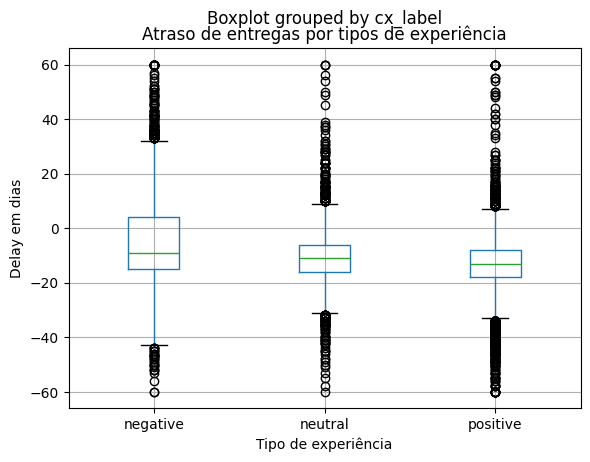

In [73]:
nlp_df.boxplot(column='delay_capped', by='cx_label')
plt.title('Atraso de entregas por tipos de experiência')
plt.xlabel('Tipo de experiência')
plt.ylabel('Delay em dias')
plt.show()

#### Análise textual e preparação do texto

Antes do NLP, todos os comentários devem passar por uma limpeza básica que padronize o texto. Isso facilitará a extração de padrões linguísticos.

In [74]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

nlp_df['cleaned_comments'] = nlp_df['review_comment_message'].apply(clean_text)

#### TF-IDF

Utilizado para identificar palavras relevantes nos comentários, não só considerando frequência mas também importância relativa no contexto.

In [ ]:
tfidf = TfidfVectorizer(
    max_features=3000,
    stop_words= portuguese_stopwords
)

X = tfidf.fit_transform(nlp_df["cleaned_comments"]) # aprende vocabulário e transforma em matriz numérica
feature_names = tfidf.get_feature_names_out()

Abaixo, os comentários negativos tendem a enfatizar termos associasdos à atraso, demora, frustração, enquanto os positivos destacam rapidez, qualidade do produto e satisfação geral.

In [ ]:
def top_words_by_label(label, n = 12):
    idx = nlp_df[nlp_df['cx_label'] == label].index # filtrando pelo label
    mean_tfidf = X[idx].mean(axis=0) # calcula médias para entender palavras mais relevantes
    top_idx = mean_tfidf.A1.argsort()[-n:] # transofrma matriz em array unidimensional e pega os índices das n maiores médias
    return [feature_names[i] for i in top_idx] # retorna a lsita das palavras

In [77]:
top_words_by_label('positive')

['entregue',
 'bem',
 'tudo',
 'excelente',
 'timo',
 'chegou',
 'entrega',
 'recomendo',
 'antes',
 'prazo',
 'bom',
 'produto']

In [78]:
top_words_by_label('negative')

['dia',
 'pedido',
 'entrega',
 'chegou',
 'nao',
 'at',
 'entregue',
 'veio',
 'comprei',
 'ainda',
 'recebi',
 'produto']

Além do atraso do prazo estimado, o tempo total de entrega também tem relação direta com experiência do cliente, reenforçando a importância da eficiência logística na percepção de qualidade.

In [79]:
nlp_df.groupby('cx_label')['delivery_time_days'].mean()

cx_label
negative    19.060541
neutral     14.027834
positive    10.772627
Name: delivery_time_days, dtype: float64

## Conclusão

##### A análise integrada dos dados logísticos, avaliações numéricas e comentários de texto evidenciam que o atraso na entrega impactam a experiência do cliente de forma muito consistente.

##### A análise textual comprova a relação já reenforçada pelos dados comparativos. Assim se reenforça a necessidade da combinação de dados estruturados e não estruturados para compreender a experiência do cliente de forma mais direta em análises de negócio reais.